<a href="https://colab.research.google.com/github/AklimaRimi/Reptile-Museum/blob/main/notebook/final_train_a_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! git clone https://github.com/AklimaRimi/Reptile-Museum.git

fatal: destination path 'Reptile-Museum' already exists and is not an empty directory.


In [4]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr onnxruntime onnx nbdev wandb
   

In [5]:
!nvidia-smi

Tue Mar 14 05:56:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:

from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import pandas as pd
import numpy as np
import torch
from fastai.metrics import accuracy
torch.cuda.is_available()
from fastai.vision.all import *
from fastcore.parallel import *

import torch
import glob2, numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm


In [8]:
df = pd.read_csv('/content/Reptile-Museum/data/final_data.csv')
df.head()

,Image,Type,Name,Scientific Name,Conservation Status,Habitant,Color,Found In,Diet
0,Reptile-Museum/augimg/Rafetus swinhoei/yRafetus swinhoei85.jpeg,Turtle,Yangtze giant softshell turtle,Rafetus swinhoei,Critically Endangered,River,Olive-Green,China,Omnivore
1,Reptile-Museum/augimg/Scelarcis perspicillata/dScelarcis perspicillata4.jpeg,Lizard,Moroccan rock lizard,Scelarcis perspicillata,Low Risk,Desert,Brown,Morocco,Insectivore
2,Reptile-Museum/augimg/Thamnophis sirtalis parietalis/yThamnophis sirtalis parietalis57.jpeg,Snake,Red-sided garter snake,Thamnophis sirtalis parietalis,Low Risk,Wet Lands,Brown,North America,Carnivore
3,Reptile-Museum/augimg/Caretta caretta/xCaretta caretta82.jpeg,Turtle,Loggerhead sea turtle,Caretta caretta,Low Risk,Ocean,Brown,All Over the World,Carnivore
4,Reptile-Museum/augimg/Mecistops cataphractus/yMecistops cataphractus67.jpeg,Crocodile,West African Slender-snouted crocodile,Mecistops cataphractus,Critically Endangered,Tropical Region,Dark-Brown,Angola,Carnivore


In [6]:
path = '/content/'

In [9]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
from fastai.vision.all import *



labels = pd.read_csv('/content/Reptile-Museum/data/final_data.csv')


with tf.device('/device:GPU:0'):
  # def get_labels(row):
  #     return [row['Scientific Name'], row['Name'], row['Type'], row['Conservation Status'],row['Habitant'],row['Color'],row['Found In'],row['Diet']]
  # def get_inp(row):
  #   return row['Image']

  dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock(add_na = True)),
                      splitter=RandomSplitter(valid_pct=.2,seed=0),
                      get_x=ColReader('Image'),
                      get_y=ColReader(['Scientific Name','Name','Type','Conservation Status','Habitant','Color','Found In','Diet']),
                      item_tfms=Resize(300),
                      
      )
  dls = dblock.dataloaders(labels, bs=34)




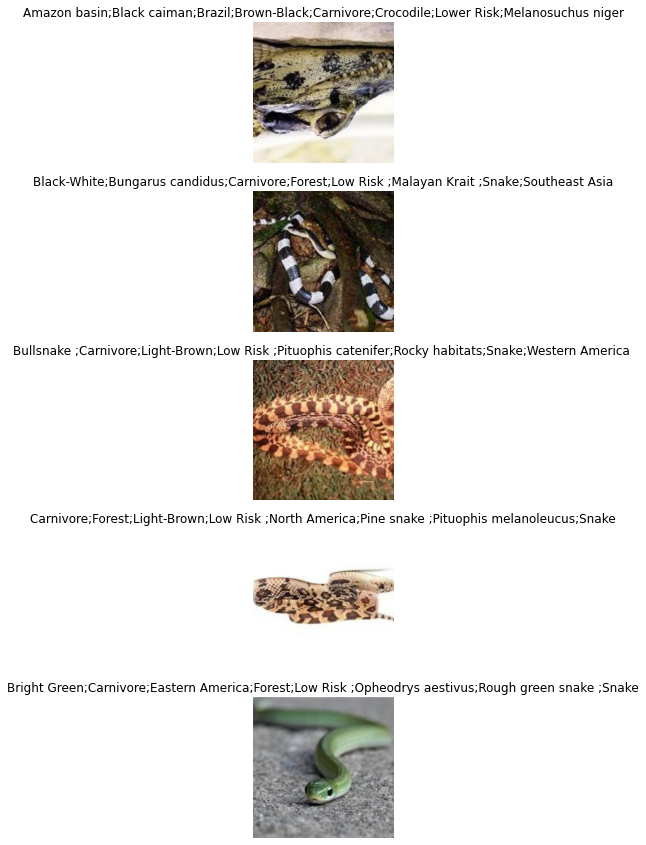

In [ ]:
with tf.device('/device:GPU:0'):
  dls.train.show_batch(max_n=5,nrows=5)

In [ ]:

with tf.device('/device:GPU:0'):
  learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()])


/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [ ]:
learn.freeze()

SuggestedLRs(valley=0.001737800776027143)

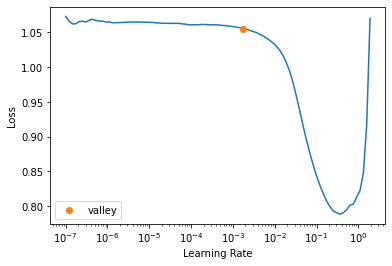

In [ ]:
learn.lr_find()

In [ ]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(1,0.001737800776027143)



epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.049759,0.039250,0.985128,0.319449,0.639494,06:08


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.00019054606673307717)

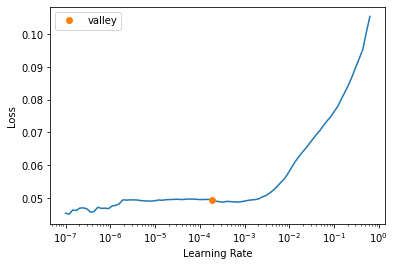

In [ ]:
learn.lr_find()

In [ ]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(5,0.00019054606673307717)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.037489,0.029638,0.989103,0.508075,0.742435,07:32
1,0.023321,0.017574,0.993610,0.722384,0.863018,07:33
2,0.013550,0.009027,0.996756,0.866598,0.938778,07:30
3,0.007736,0.005716,0.997939,0.920739,0.953075,07:32
4,0.005805,0.005284,0.998095,0.927186,0.956563,07:31


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_cl

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


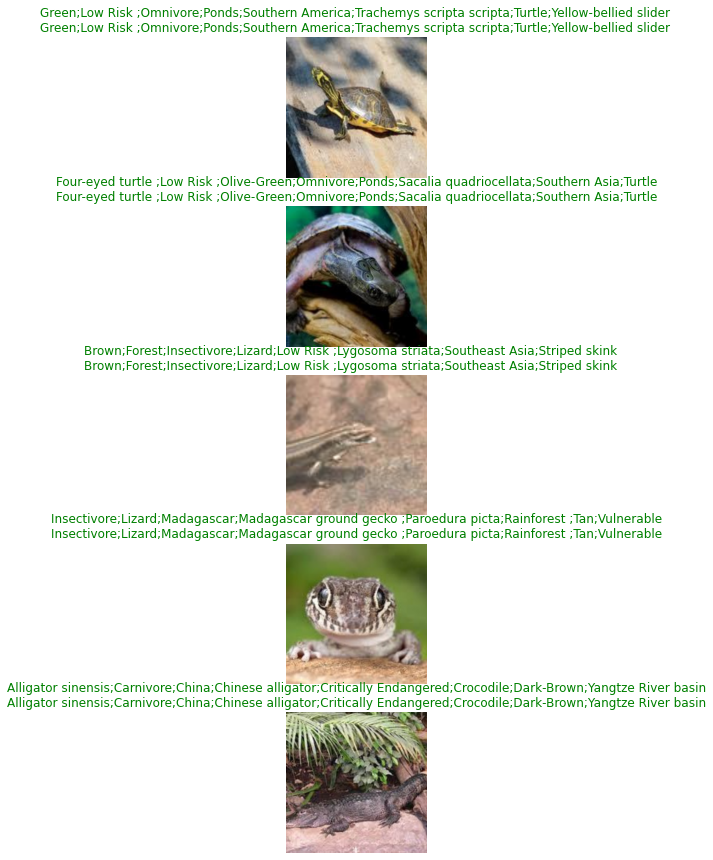

In [ ]:
with tf.device('/device:GPU:0'):  
  learn.show_results(figsize=(15,15),max_n=5,nrows=5)

In [9]:
from fastai.vision.all import *

In [ ]:
import pickle
with tf.device('/device:GPU:0'):
  learn.export('/content/drive/MyDrive/Multimodal/multi-target/model/multi_target_resnet34.pkl',)

In [15]:
from fastai.vision.all import *

learn  =  load_learner('/content/drive/MyDrive/Multimodal/multi-target/model/multi_target_resnet34.pkl',)
preds = learn.predict('/content/Reptile-Museum/test images/aAcrantophis madagascariensis21.jpeg')

print(preds[0])


['Acrantophis madagascariensis', 'Carnivore', 'Critically Endangered', 'Forest', 'Gray', 'Madagascar', 'Madagascar ground boa ', 'Snake']


In [16]:
with tf.device('/device:GPU:0'):
  learn2 = cnn_learner(dls, xresnet18_deeper, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()])

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [17]:
learn2.freeze()

SuggestedLRs(valley=0.0008317637839354575)

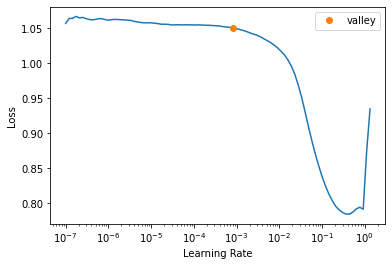

In [18]:
learn2.lr_find()

In [19]:
learn.fit_one_cycle(1,0.0008317637839354575)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.093841,0.085300,0.977100,0.018771,0.038406,05:14


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
learn2.unfreeze()

SuggestedLRs(valley=3.630780702224001e-05)

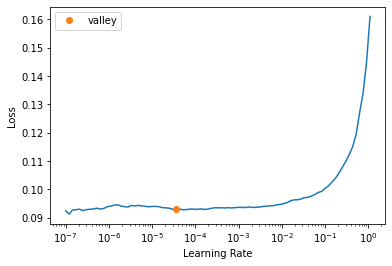

In [21]:
learn2.lr_find()

In [22]:
learn2.fit_one_cycle(5,3.630780702224001e-05)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.092591,0.084218,0.977149,0.019649,0.051920,05:42
1,0.090395,0.082487,0.977302,0.021341,0.060679,05:43
2,0.088716,0.081860,0.977435,0.024752,0.064173,05:40
3,0.088118,0.080407,0.977467,0.023887,0.061159,05:52
4,0.087311,0.079952,0.977500,0.023208,0.068224,05:40


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_cl

In [10]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
wandb.init(project='Reptile-Museum',entity='aklimarimi7',name='resnet34')

wandb: Currently logged in as: aklimarimi7. Use `wandb login --relogin` to force relogin


In [17]:
device = torch.device('cuda')

In [12]:
import tqdm

In [19]:
! pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 KB 7.4 MB/s eta 0:00:00


In [21]:
import wandb
from fastai.vision.all import *

from accelerate import notebook_launcher
from fastai.distributed import *
from fastai.callback.wandb import WandbCallback

wandb.require(experiment="service")

def train():
    with tf.device('/device:GPU:0'):
      labels = pd.read_csv('/content/Reptile-Museum/data/final_data.csv')
      dblock = DataBlock(
            blocks=(ImageBlock, MultiCategoryBlock(add_na = True)),
                          splitter=RandomSplitter(valid_pct=.2,seed=0),
                          get_x=ColReader('Image'),
                          get_y=ColReader(['Scientific Name','Name','Type','Conservation Status','Habitant','Color','Found In','Diet']),
                          item_tfms=Resize(300),
                          
          )
      dls = dblock.dataloaders(labels, bs=64)

      learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()])

      learn.fit(5)

        
notebook_launcher(train, num_processes=2)

Launching training on one GPU.


/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pt

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.064124,0.049631,0.982863,0.119820,0.380663,05:37
1,0.039002,0.029177,0.988824,0.554783,0.839672,05:21
2,0.031653,0.022910,0.991217,0.692816,0.887914,05:19
3,0.027453,0.019963,0.992374,0.737956,0.914828,05:20
4,0.025537,0.017718,0.993204,0.772310,0.915207,05:19


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_cl

In [ ]:

dummy_input = torch.randn(1, 3, 300, 300)
torch.onnx.export(learn.model, dummy_input, '/content/drive/MyDrive/Multimodal/multi-target/model/model.onnx', opset_version=14)

In [ ]:
import onnx

onnx_model = onnx.load('/content/drive/MyDrive/Multimodal/multi-target/model/model.onnx')

onnx.checker.check_model(onnx_model)

In [ ]:
import onnxruntime
from onnxruntime import *
from onnxruntime.quantization import quantize_dynamic, QuantType

ort_session = onnxruntime.InferenceSession('/content/drive/MyDrive/Multimodal/multi-target/model/model.onnx')
quantized_model_path = '/content/drive/MyDrive/Multimodal/multi-target/model/quantized_model.onnx'
quantize_dynamic(
    '/content/drive/MyDrive/Multimodal/multi-target/model/model.onnx',
    quantized_model_path,
    weight_type=QuantType.QUInt8,
)
    

In [ ]:
! pip -q install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.9 MB/s eta 0:00:

In [ ]:
import gradio as gr
from fastai.vision.all import load_learner
from fastai import *
import torch
import os
from PIL import Image



model_path  = '/content/drive/MyDrive/Multimodal/multi-target/model/multi_target_resnet34.pkl'

model = load_learner(model_path)

def result(path):    
  pred,_,probability = model.predict(path)
  return f'{pred[0]}{pred[1]}'

    


In [ ]:
path = '/content/Reptile-Museum/test images/'

image_path = []

for i in os.listdir(path):
  image_path.append(path+i) 


image = gr.inputs.Image(shape =(300,300))
label = gr.outputs.Label()

iface = gr.Interface(fn=result, inputs=image, outputs='text', examples = image_path)
iface.launch(inline = False,share = True,debug=True)

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://ee119b6323044be383.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
